In [15]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Load the data
with open('data/shell_comparison_RAL_with_prm3.json') as f:
    data = json.load(f)

# Flatten the data and load it into a pandas DataFrame
df = pd.json_normalize(data)

# Rename the columns to remove the dots
df.columns = df.columns.str.split('.').str[-1]

# df = df[df['repId'] < 5]

# Calculate n_visited/n_total
df['visit_ratio'] = df['n_visited'] / df['n_total']

# Get the maximum visit_ratio for each scene
max_visit_ratio = df.groupby('scene')['visit_ratio'].transform('max')

# Create a new column to indicate if the visit_ratio is below 0.95 times the maximum for that scene
df['low_visit_ratio'] = df['visit_ratio'] < 0.95 * max_visit_ratio

df['length_per_visited'] = df['total_path_length'] / df['n_visited']

df['time'] /= 1000

In [18]:
df[df['result'] == 'error: Planning timeout']

,result,name,prm_build_time,samples_per_goal,n_total,repId,scene,n_visited,time,total_experiment_runtime,total_path_length,approach_max_t,shell_type,visit_ratio,low_visit_ratio,length_per_visited
0,error: Planning timeout,tsp_over_prm*,15.0,8.0,200,3,lemontree2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
1,error: Planning timeout,tsp_over_prm*,15.0,8.0,500,9,peartree3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
10,error: Planning timeout,tsp_over_prm*,5.0,10.0,165,5,appletree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
15,error: Planning timeout,tsp_over_prm*,2.0,8.0,500,9,peartree3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
17,error: Planning timeout,tsp_over_prm*,10.0,8.0,500,5,peartree3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7267,error: Planning timeout,tsp_over_prm*,2.0,8.0,500,6,peartree3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
7274,error: Planning timeout,tsp_over_prm*,15.0,10.0,600,2,nectarinetree3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
7276,error: Planning timeout,tsp_over_prm*,2.0,8.0,600,3,plumtree1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
7289,error: Planning timeout,tsp_over_prm*,2.0,10.0,600,0,nectarinetree3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN


In [3]:
def get_planner_name(planner, shell_type):
    """
    Given a planner and shell type, return a user-friendly planner name.
    
    Args:
        planner (str): The name of the planner.
        shell_type (str): The type of shell.
        
    Returns:
        str: A user-friendly planner name.
    """
    if planner == 'shell_based':
        if shell_type == 'minimum_enclosing_sphere':
            return 'Sphere Shell'
        elif shell_type == 'cgal_convex_hull':
            return 'Convex Hull Shell'
    elif planner == 'tsp_over_prm*':
        return 'TSPoPRM*'
    return None


def plot_scene_data(ax, scene_runs, color_map, low_color_map, handles, labels):
    """
    Plot the scene data on the given axis.
    
    Args:
        ax (matplotlib.axis): The axis to plot the data on.
        scene_runs (DataFrame): The data for the scene.
        color_map (dict): Mapping of planner names to colors.
        low_color_map (dict): Mapping of planner names to low ratio colors.
        handles (list): List to store handles for the legend.
        labels (list): List to store labels for the legend.
    """
    # Iterate through the groups of data defined by planner and shell type
    for ((planner, st), runs) in scene_runs.groupby(['name', 'shell_type'], dropna=False):
        
        # Get the user-friendly planner name
        name = get_planner_name(planner, st)
        if not name:
            continue
        
        # Select color based on the planner name
        color = color_map[name]
        
        # Split data based on visit_ratio
        low_ratio_data = runs[runs['low_visit_ratio']]
        high_ratio_data = runs[~runs['low_visit_ratio']]
        
        # Plot the high ratio data
        h1 = ax.scatter(high_ratio_data['time'], high_ratio_data['length_per_visited'], color=color)
        
        # Store handle and label for legend if not already stored
        if name not in labels:
            handles.append(h1)
            labels.append(name)
            
        # Plot the low ratio data if present
        low_color = low_color_map[name]
        h2 = ax.scatter(low_ratio_data['time'], low_ratio_data['length_per_visited'], color=low_color, marker='x', alpha=0.5)

        # Store handle and label for legend if not already stored
        if f'{name} (lv)' not in labels:
            handles.append(h2)
            labels.append(f'{name} (lv)')


In [10]:
with open('data/tsp_over_prm_margin.json') as f:
    
    prm_df = pd.json_normalize(json.load(f))
    
    prm_df.columns = prm_df.columns.str.split('.').str[-1]


In [13]:
prm_df

,name,optimize_segments,outside_tree_margin,prm_build_time,samples_per_goal,n_total,repId,scene,n_visited,time,total_experiment_runtime,total_path_length
0,tsp_over_prm*,True,10.0,2.0,5,75,2,appletree2,69,19223,25513,359.092396
1,tsp_over_prm*,True,5.0,2.0,5,75,1,appletree2,59,22688,29518,348.079096
2,tsp_over_prm*,True,1.0,5.0,5,75,0,appletree2,74,28446,34797,354.375049
3,tsp_over_prm*,True,2.0,10.0,5,75,1,appletree2,75,48591,54812,343.040338
4,tsp_over_prm*,True,10.0,2.0,5,75,3,appletree2,59,21620,27730,297.611106
5,tsp_over_prm*,True,2.0,5.0,5,75,2,appletree2,73,33174,39490,356.813022
6,tsp_over_prm*,True,5.0,10.0,5,75,0,appletree2,74,38522,44424,337.605187
7,tsp_over_prm*,True,2.0,10.0,5,75,0,appletree2,75,46094,52144,336.034285
8,tsp_over_prm*,True,1.0,2.0,5,75,4,appletree2,72,22903,24343,344.933200
9,tsp_over_prm*,True,10.0,2.0,5,75,1,appletree2,60,18016,19472,326.203924


<AxesSubplot:xlabel='outside_tree_margin', ylabel='n_visited'>

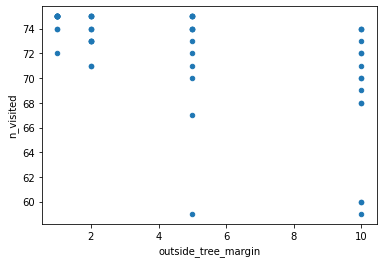

In [14]:
prm_df.plot.scatter(x='outside_tree_margin',y='n_visited')

In [7]:
prm_df.plot(x='result.total_experiment_runtime'

,parameters.planner.name,parameters.planner.optimize_segments,parameters.planner.outside_tree_margin,parameters.planner.prm_build_time,parameters.planner.samples_per_goal,parameters.problem.n_total,parameters.problem.repId,parameters.problem.scene,result.n_visited,result.time,result.total_experiment_runtime,result.total_path_length
0,tsp_over_prm*,True,10.0,5.0,3,165,2,appletree,110,44874,46543,525.191922
1,tsp_over_prm*,True,5.0,5.0,3,165,1,appletree,121,56518,58264,580.128036
2,tsp_over_prm*,True,5.0,5.0,3,165,0,appletree,127,61171,62969,617.410302
3,tsp_over_prm*,True,2.0,5.0,3,165,4,appletree,124,60078,61898,556.915492
4,tsp_over_prm*,True,10.0,5.0,3,165,3,appletree,113,42813,44558,541.092349
5,tsp_over_prm*,True,1.0,5.0,3,165,0,appletree,131,69003,70854,595.650786
6,tsp_over_prm*,True,2.0,5.0,3,165,2,appletree,127,61809,63509,581.753295
7,tsp_over_prm*,True,5.0,5.0,3,165,4,appletree,121,57859,59581,555.914989
8,tsp_over_prm*,True,1.0,5.0,3,165,4,appletree,128,79275,81002,562.581671
9,tsp_over_prm*,True,10.0,5.0,3,165,1,appletree,122,51342,53014,564.200363
